In [5]:
%%time
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import timeit
%matplotlib inline
import h5py
from pathlib import Path

from FKMC.quantum_montecarlo import quantum_cython_mcmc, update_bins
from FKMC.stats import spin_spin_correlation


config = dict(  N_steps = 200,
                N_burn_in = 0,
                N_system = 64,
                mu = 0,
                beta = 0.5,
                V=-4,
                alpha=1.25,
                U = 5,

                output_state = True,
                output_correlator=True,
                output_history=True,
                quantum = True,
                job_id = 1020242,
                bins = 20,
                N_energy_bins= 500,
                energy_max = 30,
                energy_min = 0,
               )

results = quantum_cython_mcmc(**config)
print('keys in results: ', results.keys())

#access dictionary keys as fields
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
r = objectview(results)

states = results['states']
correlation = spin_spin_correlation(r.ts)

steps = np.arange(config['N_steps'])
sites = np.arange(config['N_system'])
print(f'''
Number of occupied sites: {r.numbers.mean()}
Magnetisations of staggered spin variables: {r.magnetisations.mean()}
state.shape: {r.states.shape}
''')

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
keys in results:  dict_keys(['flag_6', 'classical_energies_moments', 'numbers_moments', 'magnetisations_moments', 'quantum_energies_moments', 'classical_energies_moments_err', 'numbers_moments_err', 'magnetisations_moments_err', 'quantum_energies_moments_err', 'correlator', 'q_energy_histogram', 'IPR_histogram', 'q_energy_histogram_bins', 'q_energy_bounds', 'classical_energies', 'numbers', 'magnetisations', 'quantum_energies', 'states', 'ts', 'eigenvalue_hist', 'eigenvector_hist'])

Number of occupied sites: 0.403671875
Magnetisations of staggered spin variables: -0.00140625
state.shape: (200, 64)

CPU times: user 16.9 s, sys: 136 ms, total: 17 s
Wall time: 4.25 s


In [2]:
import cython
%load_ext Cython

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/workspace/tch14/conda-envs/cmth_intelpython3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


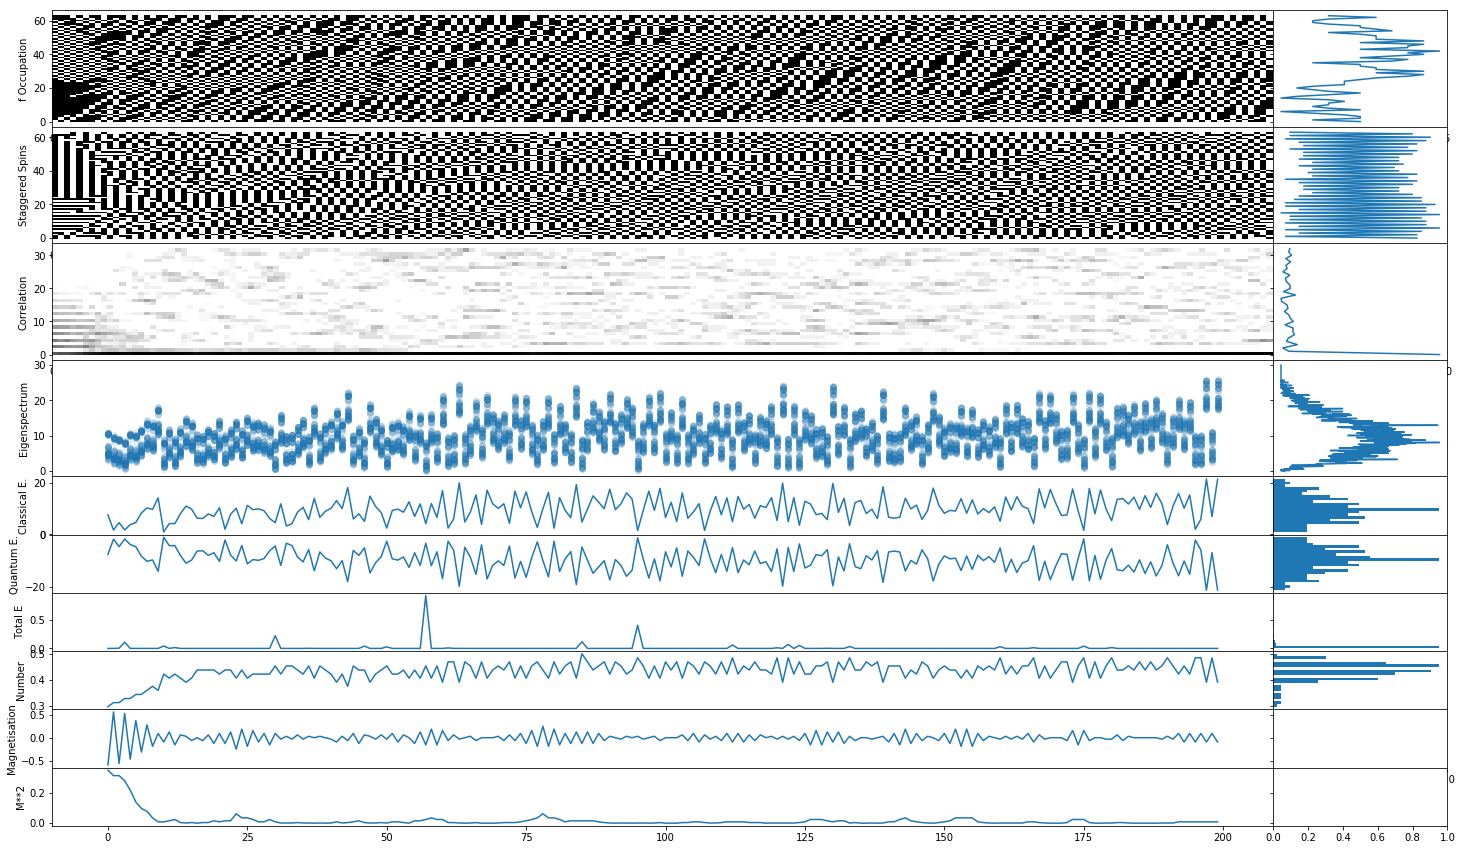

In [3]:
#things to fix

##todo
## start another phase diagram
## do a IPR vs systems plot

##look at output of phase_diagram_6 and IPR_scaling
## implement incremental saving

f, axes = plt.subplots(10,2, figsize = (25,15), sharey = 'row', gridspec_kw = dict(height_ratios=[2,2,2,2,1,1,1,1,1,1], width_ratios=[7, 1],wspace=0, hspace=0))

axs, axs1 = axes.T
observables = [_, _, _, _, 64*r.classical_energies, 64*(r.quantum_energies-r.classical_energies), 64*r.quantum_energies, r.numbers, r.magnetisations, r.magnetisations**2]
observable_ylabels = ['f Occupation', 'Staggered Spins', 'Correlation', 'Eigenspectrum','Classical E.', 'Quantum E.', 'Total E', 'Number', 'Magnetisation', 'M**2']

axs[0].pcolor(steps, sites, r.states.T, cmap = 'gray', vmin = 0, vmax = 1)
axs[1].pcolor(steps, sites, r.ts.T, cmap = 'gray', vmin = -1, vmax = 1)
axs[2].pcolor(steps, sites[:correlation.shape[-1]], 1-correlation.T, cmap = 'gray', vmin = 0, vmax = 1)

x = np.reshape(steps[:, np.newaxis] * np.ones_like(r.eigenvalue_hist), [-1,])
y = np.reshape(r.eigenvalue_hist + r.classical_energies[:, None], [-1])
axs[3].scatter(x, y, alpha = 0.1,)

#count the number of eigenvals in each square in each energy bin
indx = np.digitize(r.eigenvalue_hist, r.q_energy_histogram_bins)
#bin_averages= np.array([IPRs[indx == i].mean() for i in np.arange(len(bins))])

for ax,observable in list(zip(axs,observables))[4:]: ax.plot(steps, observable)

axs1[0].plot(r.states.mean(axis=0), sites)
axs1[1].plot(r.ts.mean(axis=0), sites)
axs1[2].plot(correlation.mean(axis=0), sites[:correlation.shape[-1]])


hist_kwargs = dict(orientation='horizontal', bins = 20, density = True)
axs1[3].plot(r.q_energy_histogram / np.sum(r.q_energy_histogram), r.q_energy_histogram_bins[:-1])

for ax,observable in list(zip(axs1,observables))[4:8]: ax.hist(observable, **hist_kwargs)

for ylabel, ax in zip(observable_ylabels, axs): ax.set(ylabel=ylabel)
axs[5].set(xlabel = 'MC Step (One trial per site per step)');

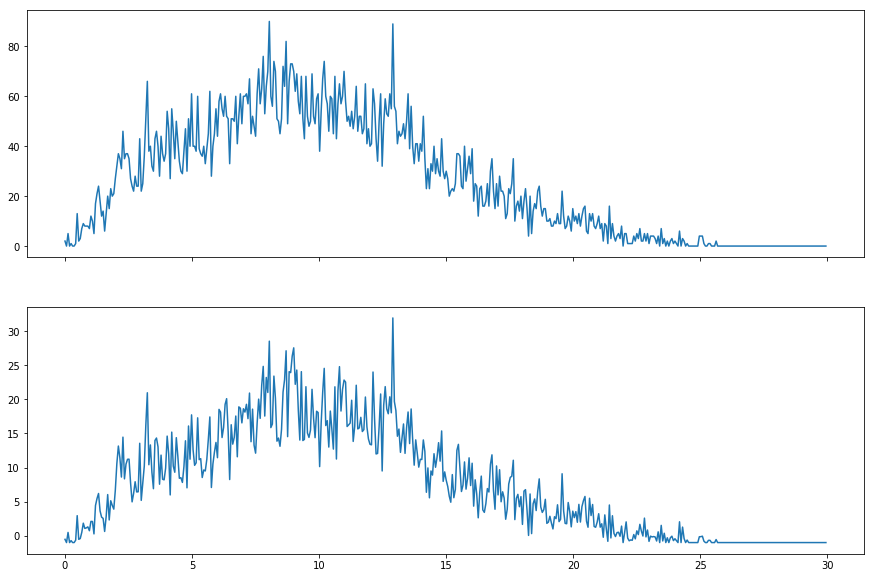

In [4]:
f, axes = plt.subplots(2,1, figsize = (15,10), sharex = 'col')

axes[0].plot(r.q_energy_histogram_bins[:-1], r.q_energy_histogram)
axes[1].plot(r.q_energy_histogram_bins[:-1], r.IPR_histogram)

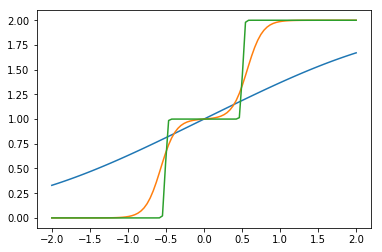

/workspace/tch14/conda-envs/cmth_intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


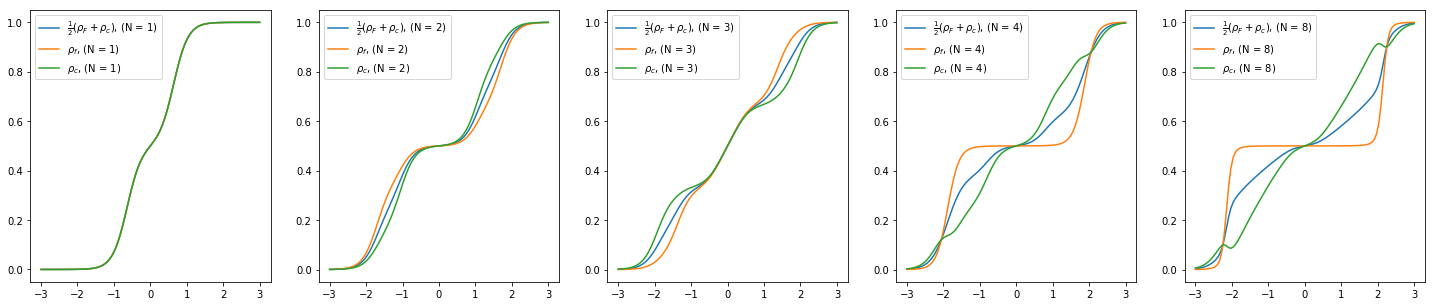

In [215]:
def solve_H(state, mu, beta, U, J):
    muf = muc = mu
    if state.size == 1:
        evals = np.array([U*(state - 1/2)])
        evecs = np.array([1,])
    else:
        evals, evecs = eigh_tridiagonal(d = U*(state - 1/2), e =-1*np.ones(state.shape[0] - 1), lapack_driver = 'stev')
        
    Ff = - U/2*np.sum(state - 1/2) - muf*np.sum(state) + (state - 1/2).T @ J @ (state - 1/2)
    Fc = - 1/beta * np.sum(np.log(1 + np.exp(beta * (muc - evals))))
    return Ff, Fc, evals, evecs

def direct_N(system_size, mu, beta, U, J):
    Z = 0
    Nf = 0
    Nc = 0
    muf = muc = mu
    for state in product((0,1), repeat = system_size):
        state = np.array(state)
        if system_size > 1:
            Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J)
        elif system_size == 1:
            evals = np.array([U*(state - 1/2)])
            Ff = - U/2*np.sum(state - 1/2) - muf*np.sum(state)
            Fc = - 1/beta * np.sum(np.log(1 + np.exp(beta * (muc - evals))))    

        Boltz_factor = np.exp(- beta * (Ff + Fc))
        #print(Boltz_factor)
        Z += Boltz_factor
        Nf += np.sum(state) * Boltz_factor
        Nc += np.sum(1 / (1 + np.exp(-beta * (muc - evals)))) * Boltz_factor
    
    return Nf / Z, Nc / Z

beta = 5
U = 1
J = 1

mu = np.linspace(-3,3,100)
Ns = [1,2,3,4,8]

f, axes = plt.subplots(1,len(Ns),figsize = (len(Ns)*5,5))
for ax, N in zip(axes, Ns):
    J_matrix = interaction_matrix(N, 1.5, J, normalise = True, dtype = np.float64)
    Nf, Nc = np.array([direct_N(N, m, beta, U, J=J_matrix) for m in mu]).T
    Nt = (Nf + Nc)
    ax.plot(mu, Nt/(2*N), label = r'$\frac{1}{2}(\rho_F + \rho_c)$,' +f' (N = {N})')
    ax.plot(mu, Nf/N, label = r'$\rho_f$,'+ f' (N = {N})')
    ax.plot(mu, Nc/N, label = r'$\rho_c$,'+ f' (N = {N})')
    ax.legend()
        
        

CPU times: user 5.06 s, sys: 4 ms, total: 5.06 s
Wall time: 5.06 s


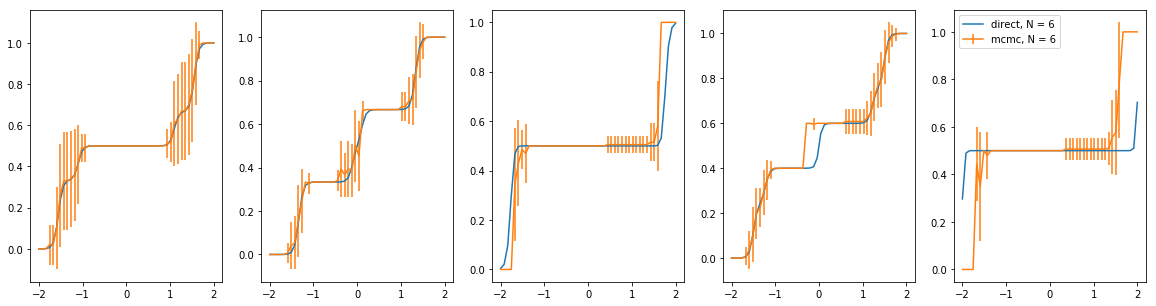

In [192]:
%%time
from scipy.linalg import eigh_tridiagonal, LinAlgError, circulant
from math import exp

def interaction_matrix(N, alpha, V, normalise = True, dtype = np.float64):
    alternating_signs = 2*(np.arange(1,N) % 2) - 1
    row0 = alternating_signs * np.abs((N/np.pi * np.sin(np.pi * np.arange(1,N, dtype = dtype)/N)) ** (-alpha))
    row0 = np.concatenate([[0,], row0])# put the first 0 in by hand
    if normalise: row0 = row0 / np.sum(row0)
    row0 = V * row0
    return circulant(row0)

def FK_mcmc(
    state,            
    N_steps = 100, N_burn_in = 10,
    mu = 0, beta = 0.1, V=1, alpha=1.5, U = 1
    ):
    
    random_numbers = np.random.rand(N_steps + N_burn_in, state.shape[0])
    J = interaction_matrix(state.shape[0], 1.5, 1, normalise = True, dtype = np.float64)
    Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J)
    old_F = Ff + Fc
    
    Fcs,Ffs = np.zeros((2,N_steps), dtype = np.float64)
    Classical_Fs = np.zeros(N_steps, dtype = np.float64)
    states = np.zeros((N_steps,state.shape[0]), dtype = np.float64)
    eigen_val_list = np.zeros((N_steps,state.shape[0]), dtype = np.float64)
    numbers = np.zeros(N_steps, dtype = np.float64)
    
    for i in range(N_steps + N_burn_in):
        for site in range(state.shape[0]):
            state[site] = 1 if state[site] == 0 else 0
            Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J)
            dF = (Ff+Fc) - old_F
            
            #if the move is rejected flip the site back and pretend nothing happened
            if dF > 0 and exp(- beta * dF) < random_numbers[i, site]:
                state[site] = 1 if state[site] == 0 else 0
            else:
                old_F = Ff+Fc
    
        if i >= N_burn_in:
                j = i - N_burn_in
                Ffs[j] = Ff
                Fcs[j] = Fc
                states[j] = state
                eigen_val_list[j] = evals 
                numbers[j] = np.sum(state)
    
    return Fs, Classical_Fs, states, eigen_val_list, numbers


beta = 20
U = 1
mu = np.linspace(-2,2,50)
N_steps = 50
alpha = 1.5
V = 1

Ns = np.arange(2,7)
f, axes = plt.subplots(1, len(Ns), figsize = (20,5))

for ax,N in zip(axes,Ns):
    J = interaction_matrix(N, alpha, V=V, normalise = True, dtype = np.float64)
    Nf, Nc = np.array([direct_N(N, m, beta, U, J=J) for m in mu]).T
    Nt = (Nf + Nc) / N
    ax.plot(mu, Nf / N, label = f'direct, N = {N}')
    

    Nmcmc, dNmcmc = np.zeros((2,mu.shape[0]), dtype = np.float64)
    for i,m in enumerate(mu):
        state = np.zeros(N, dtype = np.float64)
        Fs, Classical_Fs, states, eigen_val_list, numbers = FK_mcmc(
        state,            
        N_steps = N_steps, N_burn_in = 0,
        mu = m, beta = beta, V=V, alpha=alpha, U = U
        )  
        
        Nmcmc[i] = np.mean(numbers) / N
        dNmcmc[i] = np.std(numbers) / N
    
    ax.errorbar(mu, Nmcmc, yerr = dNmcmc, label = f'mcmc, N = {N}')
    
plt.legend()
#plt.savefig()